In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score as dbs

In [2]:
# read dataset
dfA = pd.read_csv('Datasets//Aggregation.txt', header=None , sep = ' ')
dfD = pd.read_csv('Datasets//D31.txt', header=None , sep = ' ')
dfR = pd.read_csv('Datasets//R15.txt', header=None , sep = ' ')

In [3]:
dfA.info()
dfA.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       788 non-null    float64
 1   1       788 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,0,1
0,15.55,28.65
1,14.90,27.55
2,14.45,28.35
3,14.15,28.80
4,13.75,28.05


In [4]:
dfD.info()
dfD.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3100 non-null   float64
 1   1       3100 non-null   float64
dtypes: float64(2)
memory usage: 48.6 KB


,0,1
0,25.0514,5.7475
1,26.6614,7.3414
2,25.2653,6.2466
3,25.2285,4.7447
4,25.7529,5.1564


In [5]:
dfR.info()
dfR.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       600 non-null    float64
 1   1       600 non-null    float64
dtypes: float64(2)
memory usage: 9.5 KB


,0,1
0,9.802,10.132
1,10.350,9.768
2,10.098,9.988
3,9.730,9.910
4,9.754,10.430


Text(0.5, 1.0, 'Aggregation')

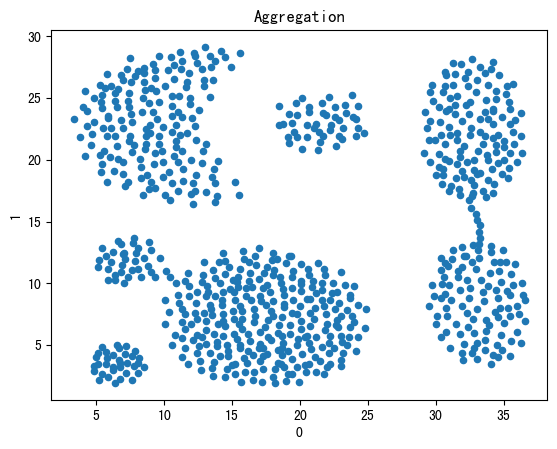

In [6]:
dfA.plot.scatter(x=0,y=1)
plt.title("Aggregation")

Text(0.5, 1.0, 'D31')

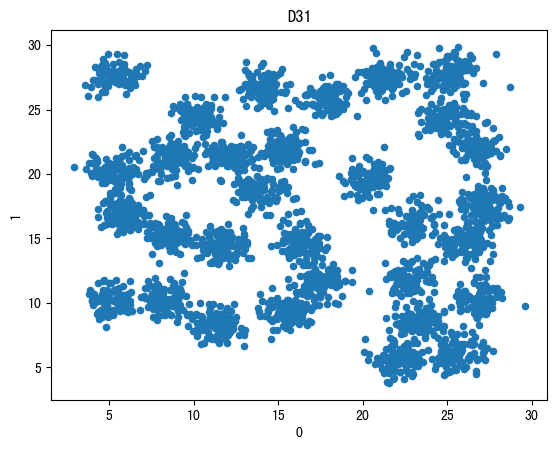

In [7]:
dfD.plot.scatter(x=0,y=1)
plt.title("D31")

Text(0.5, 1.0, 'R15')

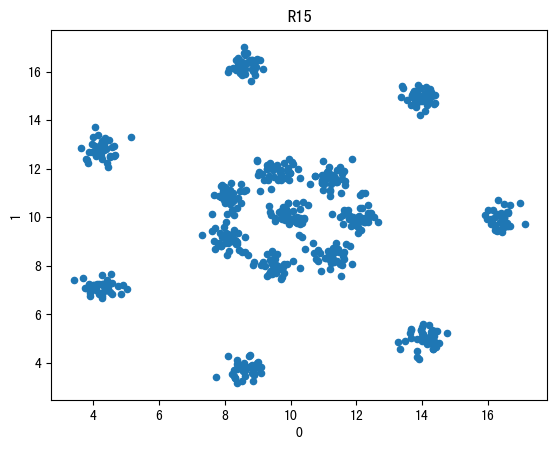

In [8]:
dfR.plot.scatter(x=0,y=1)
plt.title("R15")

In [28]:
class DPC(object):
    def __init__(self, dc, thr_rho, thr_delta,kernel):
        self.dc = dc
        self.d = None
        self.rho = None
        self.delta = None
        self.thr_rho =thr_rho
        self.thr_delta = thr_delta
        self.kernel = kernel
        self.center = None

    def GetDistance(self):
        self.d = np.zeros([self.m,self.m])
        for i in range(self.m):
            for j in range(i+1,self.m):
                self.d[i][j] = np.sqrt(np.sum((self.X[i] - self.X[j]) ** 2))
                self.d[j][i] = self.d[i][j]

    def GetRho(self):
        self.rho = np.zeros(self.m)
        if self.kernel == 'cut-off':
            dd = self.d - self.dc
            for i,di in enumerate(dd):
                self.rho[i] = di[di<0].size
        if self.kernel == 'Gaussian':
            self.rho = np.sum(np.exp(-self.d/self.dc) ** 2, axis = 1)

    def GetDelta(self):
        self.delta = np.zeros(self.m)
        sort_index = np.argsort(-self.rho)
        self.index = sort_index
        self.delta[sort_index[0]] = np.max(self.d[sort_index[0]])
        for i in range(1,self.m):
            self.delta[sort_index[i]] = np.min(self.d[sort_index[i]][sort_index[0:i]])

    def Cluster(self,X):
        self.X = X
        self.m, self.n = self.X.shape
        self.GetDistance()
        self.GetRho()
        self.GetDelta()
        self.c = np.zeros(self.m)
        self.center = []
        cn = 0
        for i in range(self.m):
            # 聚类中心
            if self.rho[i]>=self.thr_rho and self.delta[i]>=self.thr_delta:
                cn+=1
                self.center.append(i)
                self.c[i]=cn
            # 异常点
            elif self.rho[i]<self.thr_rho and self.delta[i]>=self.thr_delta:
                self.c[i] = -1
        # 剩余点
        for i in range(self.m):
            if self.c[self.index[i]] == 0:
                j = np.argmin(self.d[self.index[i]][self.index[:i]])
                self.c[self.index[i]] = self.c[self.index[j]]

        print(f'共{cn}个cluster')

    def draw_decision_graph(self):
        plt.scatter(self.rho, self.delta,alpha=0.5)
        plt.hlines(self.thr_delta,0,np.max(self.rho),linestyles='--',colors="lightcoral")
        plt.vlines(self.thr_rho,0,np.max(self.delta),linestyles='--',colors='lightcoral')
        plt.xlabel("rho")
        plt.ylabel("delta")
        plt.title(f'决策图\n kernel={self.kernel}, dc={self.dc}, thr_rho={self.thr_rho}, thr_delta={self.thr_delta}')
        plt.show()
        print("聚类中心：")
        for i in self.center:
            print("rho:",self.rho[i]," delta:",self.delta[i],"数据点:",self.X[i])
        print("异常点：")
        print("rho: ",self.rho[np.where(self.c==-1)]," delta: ",self.delta[np.where(self.c==-1)], "数据点:", self.X[np.where(self.c==-1)])

    def draw_result(self):
        plt.scatter(x=self.X[:, 0], y=self.X[:, 1], c=self.c,cmap='gist_rainbow',alpha=0.4)
        plt.scatter(x=self.X[self.center][:, 0], y=self.X[self.center][:, 1], marker="x", s=50, c="r")
        plt.title(f'分簇结果\n kernel={self.kernel}, dc={self.dc}, thr_rho={self.thr_rho}, thr_delta={self.thr_delta}')
        plt.show()

In [10]:
# data preprocessing
dfA = np.array((dfA-dfA.min())/(dfA.max()-dfA.min()))

In [11]:
dfD = np.array((dfD-dfD.min())/(dfD.max()-dfD.min()))

In [12]:
dfR = np.array((dfR-dfR.min())/(dfR.max()-dfR.min()))

共7个cluster


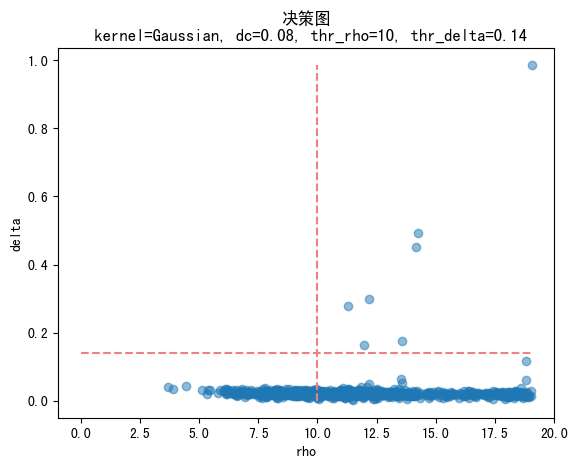

聚类中心：
rho: 14.16366179386259  delta: 0.45228153442147856 数据点: [0.1686747  0.74448529]
rho: 11.960983146456545  delta: 0.16345535310634346 数据点: [0.11295181 0.36764706]
rho: 19.053596557019603  delta: 0.9861867171163006 数据点: [0.4126506  0.11580882]
rho: 12.164807704686815  delta: 0.2993733475761586 数据点: [0.90813253 0.27022059]
rho: 14.258517403957894  delta: 0.49268833756639085 数据点: [0.87198795 0.65808824]
rho: 11.305659158237926  delta: 0.2790768986532394 数据点: [0.53614458 0.77205882]
rho: 13.594868214574376  delta: 0.17629866329748878 数据点: [0.10240964 0.05882353]
异常点：
rho:  []  delta:  [] 数据点: []


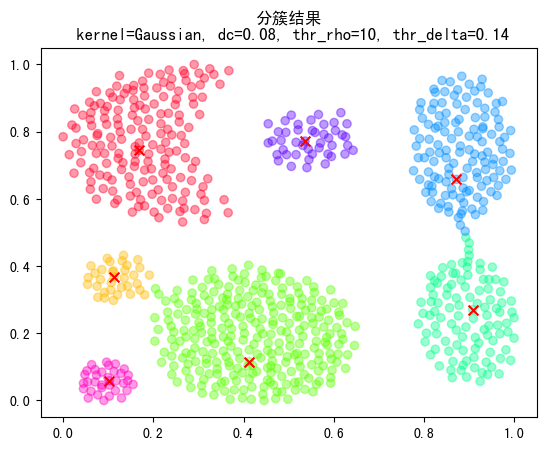

DBI： 0.5435124431628843


In [29]:
dc = 0.08
thr_rho = 10
thr_delta = 0.14
kernel = 'Gaussian'

dpc1 = DPC(dc,thr_rho,thr_delta,kernel)
dpc1.Cluster(dfA)
dpc1.draw_decision_graph()
dpc1.draw_result()
print('DBI：', dbs(dfA, dpc1.c))

In [14]:
dA = np.triu(dpc1.d,0)
dA = dA[np.where(dA!=0)].flatten()
dA = np.sort(dA)
print(dA[int(len(dA)*0.01)])
print(dA[int(len(dA)*0.02)])

0.04340283322039654
0.0619844056951599


共31个cluster


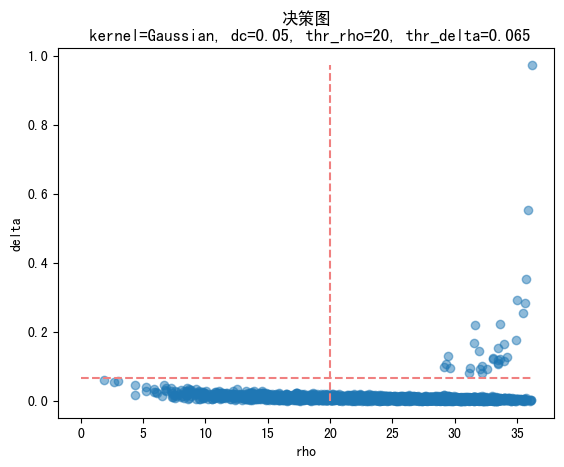

聚类中心：
rho: 32.18617452206885  delta: 0.1013195465386932 数据点: [0.83702491 0.08313476]
rho: 35.88562793646806  delta: 0.5527107407793451 数据点: [0.55089201 0.30420969]
rho: 29.62455944438822  delta: 0.09402806937548175 数据点: [0.19701801 0.24993381]
rho: 36.18189460876043  delta: 0.9730981403849877 数据点: [0.81651297 0.79242785]
rho: 29.347707134254847  delta: 0.10586388055748734 数据点: [0.08075498 0.62757038]
rho: 33.462350523072466  delta: 0.15347178044080065 数据点: [0.89425149 0.2484335 ]
rho: 33.11216921042793  delta: 0.1232596926619309 数据点: [0.68602948 0.89974406]
rho: 31.214897680390596  delta: 0.09517206717980058 数据点: [0.41135913 0.5782367 ]
rho: 35.49460933160964  delta: 0.2536691709745524 数据点: [0.56709472 0.84282058]
rho: 34.197144598362975  delta: 0.12587486061764278 数据点: [0.34973714 0.66975554]
rho: 32.62187676068731  delta: 0.09326960600158316 数据点: [0.76083771 0.17721296]
rho: 33.104146245805026  delta: 0.12266444329916193 数据点: [0.87210204 0.42246933]
rho: 32.02068510291562  delta: 0.0

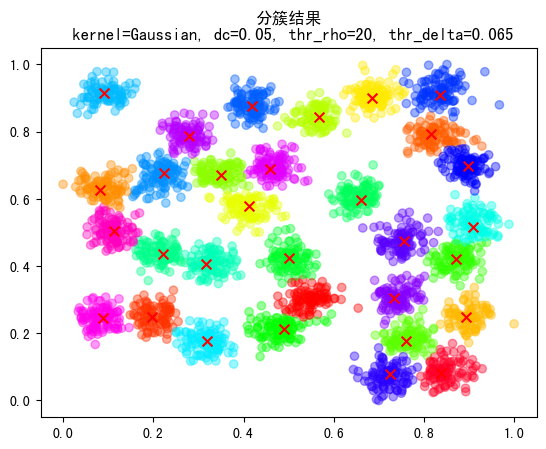

DBI： 0.5520423239381427


In [31]:
dc = 0.05
thr_rho = 20
thr_delta = 0.065
kernel = 'Gaussian'

dpc2 = DPC(dc,thr_rho,thr_delta,kernel)
dpc2.Cluster(dfD)
dpc2.draw_decision_graph()
dpc2.draw_result()
print('DBI：', dbs(dfD, dpc2.c))

In [16]:
dD = np.triu(dpc2.d,0)
dD = dD[np.where(dD!=0)].flatten()
dD = np.sort(dD)
print(dD[int(len(dD)*0.01)])
print(dD[int(len(dD)*0.02)])

0.03464680898025917
0.05424704629717776


共15个cluster


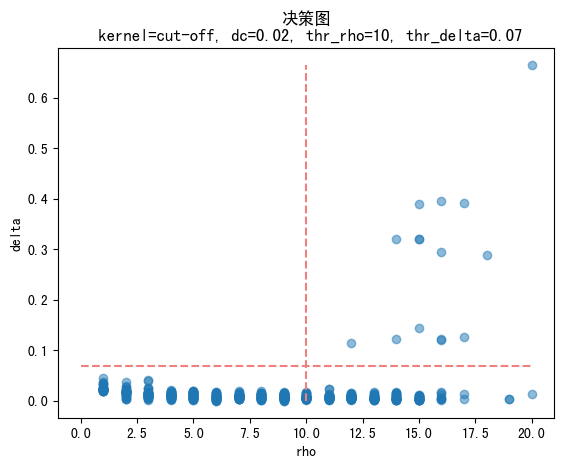

聚类中心：
rho: 14.0  delta: 0.12177780997729562 数据点: [0.49205655 0.48012144]
rho: 16.0  delta: 0.12092269519559948 数据点: [0.63358111 0.48200087]
rho: 15.0  delta: 0.14381387710499613 数据点: [0.55983093 0.6054648 ]
rho: 12.0  delta: 0.11502250644864004 数据点: [0.44075208 0.63481278]
rho: 20.0  delta: 0.6653716587267169 数据点: [0.33872613 0.54705797]
rho: 16.0  delta: 0.12347933573368522 数据点: [0.35155225 0.42359404]
rho: 17.0  delta: 0.12751417632522521 数据点: [0.45168343 0.33945352]
rho: 18.0  delta: 0.28989479712204025 数据点: [0.57353156 0.37704207]
rho: 15.0  delta: 0.3197928726738887 数据点: [0.95321382 0.49212086]
rho: 16.0  delta: 0.3951930713563003 数据点: [0.76621484 0.85427208]
rho: 15.0  delta: 0.3892852530777385 数据点: [0.38332605 0.95243603]
rho: 15.0  delta: 0.3208435847926432 数据点: [0.05334499 0.69799046]
rho: 17.0  delta: 0.3917069867822488 数据点: [0.04868095 0.28379355]
rho: 16.0  delta: 0.2954540062306965 数据点: [0.37880775 0.04698569]
rho: 14.0  delta: 0.32020457287844545 数据点: [0.78720303 0.136330

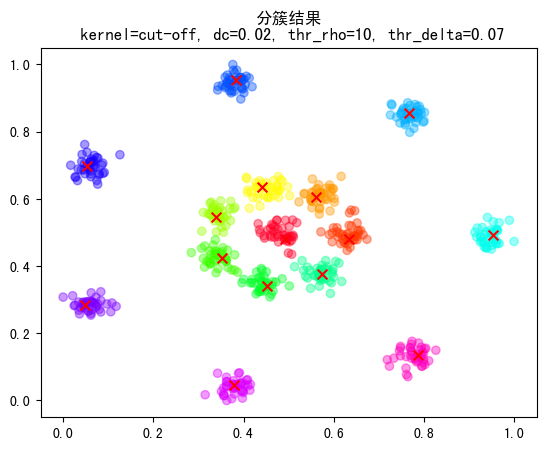

DBI： 0.31471445116423397


In [30]:
dc = 0.02
thr_rho = 10
thr_delta = 0.07
kernel = 'cut-off'

dpc3 = DPC(dc,thr_rho,thr_delta,kernel)
dpc3.Cluster(dfR)
dpc3.draw_decision_graph()
dpc3.draw_result()
print('DBI：', dbs(dfR, dpc3.c))

In [18]:
dR = np.triu(dpc3.d,0)
dR = dR[np.where(dR!=0)].flatten()
dR = np.sort(dR)
print(dR[int(len(dR)*0.01)])
print(dR[int(len(dR)*0.02)])

0.018080037097359655
0.026812134441483147
